# Bidirectional trajectories of stroke and psychosis: A 16-year longitudinal population study of older adults

## Psychosis After Stroke analysis

In [43]:
library(dplyr)
library(survival)
library(survminer)
library(forestmodel)

Load pre-processed dataframe created by Stroke_Psychosis_ELSA_Pre-processing.R

In [2]:
transformed_data_dir = "/home/main/data/StrokePsychosisELSATransformedData/"
transformed_data_filename = paste(transformed_data_dir, "waves12345.rda", sep="")

load(file = transformed_data_filename)

#### Recode and arrange data

In [3]:
psychosisinstroke_surv <- waves12345 %>%
  select(idauniq, wavefirstparticipate, wavelastparticipate, wavefirstreport_stroke, wavefirstreport_psychosis, strokeever, psychosisever, 
         w1age, sex, ethnicgroup, alcoholbaseline, smokingbaseline, vigorousactbaseline, netwealth_q5, region, age_cat)

#Get data into right format
psychosisinstroke_surv$wavefirstparticipate <- as.numeric(psychosisinstroke_surv$wavefirstparticipate)
psychosisinstroke_surv$wavelastparticipate <- as.numeric(psychosisinstroke_surv$wavelastparticipate)
psychosisinstroke_surv$wavefirstreport_stroke <- as.numeric(psychosisinstroke_surv$wavefirstreport_stroke)
psychosisinstroke_surv$wavefirstreport_psychosis <- as.numeric(psychosisinstroke_surv$wavefirstreport_psychosis)
psychosisinstroke_surv$strokeever <- as.numeric(psychosisinstroke_surv$strokeever)
psychosisinstroke_surv$psychosisever <- as.numeric(psychosisinstroke_surv$psychosisever)
psychosisinstroke_surv$netwealth_q5 <- factor(psychosisinstroke_surv$netwealth_q5, levels = c(5, 4, 3, 2, 1))

#Assign numeric labels to cateogrical variables (reference group == 1 i.e. the most healthy level of the variable). 
#If the categories are used then results are not shown in an order than makes sense.

#Vigorous physical activity
psychosisinstroke_surv$vigorousactbaseline[psychosisinstroke_surv$vigorousactbaseline == "hardly ever, or never"] <- 4
psychosisinstroke_surv$vigorousactbaseline[psychosisinstroke_surv$vigorousactbaseline == "more than once a week"] <- 1
psychosisinstroke_surv$vigorousactbaseline[psychosisinstroke_surv$vigorousactbaseline == "once a week"] <- 2
psychosisinstroke_surv$vigorousactbaseline[psychosisinstroke_surv$vigorousactbaseline == "one to three times a month"] <- 3
#table(psychosisinstroke_surv$vigorousactbaseline)

#Alcohol use
psychosisinstroke_surv$alcoholbaseline[psychosisinstroke_surv$alcoholbaseline == "1-4 times/week"] <- 5
psychosisinstroke_surv$alcoholbaseline[psychosisinstroke_surv$alcoholbaseline == "Daily/almost daily"] <- 4
psychosisinstroke_surv$alcoholbaseline[psychosisinstroke_surv$alcoholbaseline == "Monthly"] <- 3
psychosisinstroke_surv$alcoholbaseline[psychosisinstroke_surv$alcoholbaseline == "Not at all"] <- 1
psychosisinstroke_surv$alcoholbaseline[psychosisinstroke_surv$alcoholbaseline == "Rarely/special occasions only"] <- 2
#table(psychosisinstroke_surv$alcoholbaseline)
#table(psychosisinstroke_surv$ethnicgroup)

#Rename variables with more print appropriate names (these appear directly on the forest plot/outputs)
psychosisinstroke_surv <- psychosisinstroke_surv %>% 
  mutate(`Age at Wave 1` = w1age,
         `Wealth quintile` = netwealth_q5,
         `Stroke status` = strokeever,
         Sex = sex,
         `Ethnic group` = ethnicgroup,
         `Alcohol consumption` = alcoholbaseline,
         `Smoking status` = smokingbaseline,
         `Vigorous activity` = vigorousactbaseline)

#Create follow-up time variables
psychosisinstroke_surv <- psychosisinstroke_surv %>%
  mutate(fuptime = case_when(psychosisever == 1 & strokeever == 0 ~ wavefirstreport_psychosis - wavefirstparticipate, #psychosis but no stroke, f-up starts from wave first participated until first report of psychosis
                              psychosisever == 0 & strokeever == 1 ~ wavelastparticipate - wavefirstreport_stroke, #stroke but no psychosis, f-up starts from wave stroke first reported until wave last participated
                              psychosisever == 0 & strokeever == 0 ~ wavelastparticipate - wavefirstparticipate, #no stroke and no psychosis, use full available follow-up (from first wave to last wave participated)
                              wavefirstreport_psychosis > 0 & wavefirstreport_psychosis < wavefirstreport_stroke ~ 0, #if first psychosis report happened prior to report of stroke, then f-up time = 0
                              wavefirstreport_stroke == wavefirstreport_psychosis ~ 0, #if stroke and psychosis reported at the same time, then f-up time = 0
                              psychosisever == 1 & strokeever == 1 ~ wavefirstreport_psychosis - wavefirstreport_stroke, #psychosis and stroke, f-up starts from first report of stroke until psychosis is reported
                              TRUE ~ 999))      
 # no 999s appear so everyone has been coded as per the above

#Convert follow-up time from waves to years (follow-up occurred every two years i.e. *2)
psychosisinstroke_surv <- psychosisinstroke_surv %>%
  mutate(fuptime = fuptime * 2)


Summarise follow-up time (in years)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   2.000   6.000   7.169  12.000  17.000 

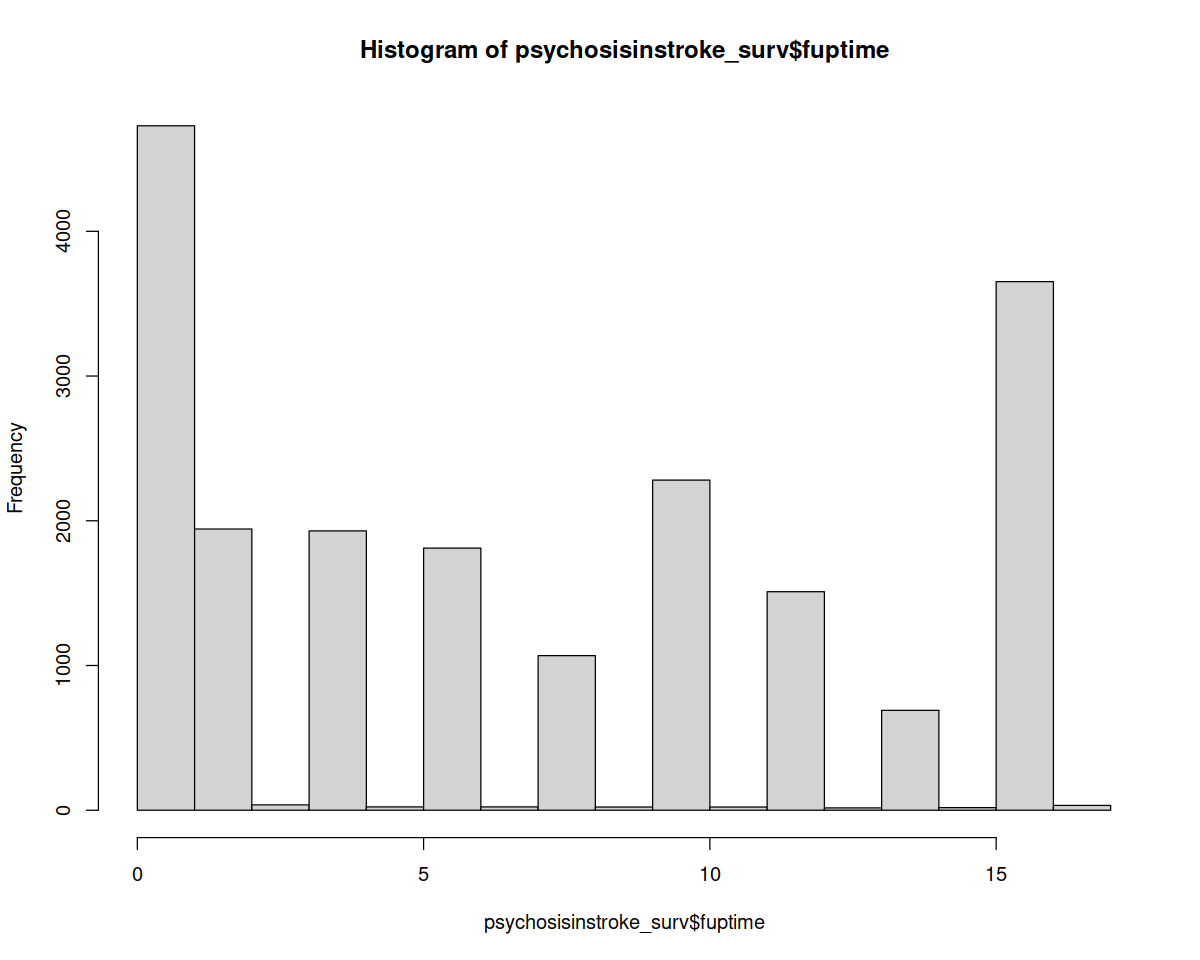

In [4]:
summary(psychosisinstroke_surv$fuptime)

options(repr.plot.width=10, repr.plot.height=8)
hist(psychosisinstroke_surv$fuptime)

Summarise by psychosis status

In [5]:
psychosisinstroke_surv %>%
  group_by(strokeever) %>%
  summarise(mean = mean(fuptime), 
            median = median(fuptime), 
            iqr_low = quantile(fuptime, probs =c(.25)), 
            iqr_upper = quantile(fuptime, probs =c(.75))
  )

strokeever,mean,median,iqr_low,iqr_upper
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,7.349613,6,2,12
1,4.900821,4,1,8


#### Build survival model

In [6]:
survobj <- Surv(time = psychosisinstroke_surv$fuptime,
                event = psychosisinstroke_surv$psychosisever)

#### Produce Kaplan-Meier estimates and curves

This creates and summarises an overall survival curve on the entire sample

In [7]:
surv_fit <- survfit(survobj ~ 1)
summary(surv_fit)
print(surv_fit, print.rmean = TRUE) # print.rmean shows the mean survival time

Call: survfit(formula = survobj ~ 1)

 time n.risk n.event survival  std.err lower 95% CI upper 95% CI
    0  19808      82    0.996 0.000456        0.995        0.997
    1  15176       3    0.996 0.000470        0.995        0.997
    2  15079      15    0.995 0.000535        0.994        0.996
    4  13099      18    0.993 0.000623        0.992        0.995
    6  11146      11    0.992 0.000689        0.991        0.994
    8   9312      11    0.991 0.000774        0.990        0.993
   10   8222      10    0.990 0.000862        0.988        0.992
   12   5919       5    0.989 0.000939        0.987        0.991
   14   4393       4    0.988 0.001040        0.986        0.990
   16   3685       3    0.987 0.001138        0.985        0.990

Call: survfit(formula = survobj ~ 1)

         n     events     *rmean *se(rmean)     median    0.95LCL    0.95UCL 
  1.98e+04   1.62e+02   1.69e+01   1.13e-02         NA         NA         NA 
    * restricted mean with upper limit =  17 


#### Stratified survival

In [8]:
psychosisinstroke_fit <- survfit(Surv(fuptime, psychosisever) ~ strokeever, data = psychosisinstroke_surv)
psychosisinstroke_fit # ?not possible to calculate median survival here as not enough events accrued during follow-up to reach median
summary(psychosisinstroke_fit)
print(psychosisinstroke_fit, print.rmean = TRUE) # print.rmean shows the mean survival time

Call: survfit(formula = Surv(fuptime, psychosisever) ~ strokeever, 
    data = psychosisinstroke_surv)

                 n events median 0.95LCL 0.95UCL
strokeever=0 18346    138     NA      NA      NA
strokeever=1  1462     24     NA      NA      NA

Call: survfit(formula = Surv(fuptime, psychosisever) ~ strokeever, 
    data = psychosisinstroke_surv)

                strokeever=0 
 time n.risk n.event survival  std.err lower 95% CI upper 95% CI
    0  18346      68    0.996 0.000449        0.995        0.997
    2  14074      13    0.995 0.000516        0.994        0.996
    4  12354      13    0.994 0.000591        0.993        0.995
    6  10593      11    0.993 0.000668        0.992        0.995
    8   8903      11    0.992 0.000763        0.991        0.994
   10   7910      10    0.991 0.000859        0.989        0.992
   12   5723       5    0.990 0.000941        0.988        0.992
   14   4256       4    0.989 0.001049        0.987        0.991
   16   3605       3    0.988 0.001151        0.986        0.990

                strokeever=1 
 time n.risk n.event survival std.err lower 95% CI upper 95% CI
    0   1462      14    0.990 0.00255        0.985        0.995
    1   1102       3    0.988 0.00298        0.982       

Call: survfit(formula = Surv(fuptime, psychosisever) ~ strokeever, 
    data = psychosisinstroke_surv)

                 n events *rmean *se(rmean) median 0.95LCL 0.95UCL
strokeever=0 18346    138   16.9     0.0111     NA      NA      NA
strokeever=1  1462     24   16.7     0.0659     NA      NA      NA
    * restricted mean with upper limit =  17 


#### Compute log rank test statistic (test of whether the curves are overlapping or not)

In [9]:
survdiff(
  Surv(fuptime, psychosisever) ~ strokeever,
  data = psychosisinstroke_surv
)

Call:
survdiff(formula = Surv(fuptime, psychosisever) ~ strokeever, 
    data = psychosisinstroke_surv)

                 N Observed Expected (O-E)^2/E (O-E)^2/V
strokeever=0 18346      138    151.9      1.28      20.7
strokeever=1  1462       24     10.1     19.33      20.7

 Chisq= 20.7  on 1 degrees of freedom, p= 5e-06 

#### Generate survival curves plot

Warning message in .add_surv_median(p, fit, type = surv.median.line, fun = fun, :
“Median survival not reached.”
Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”


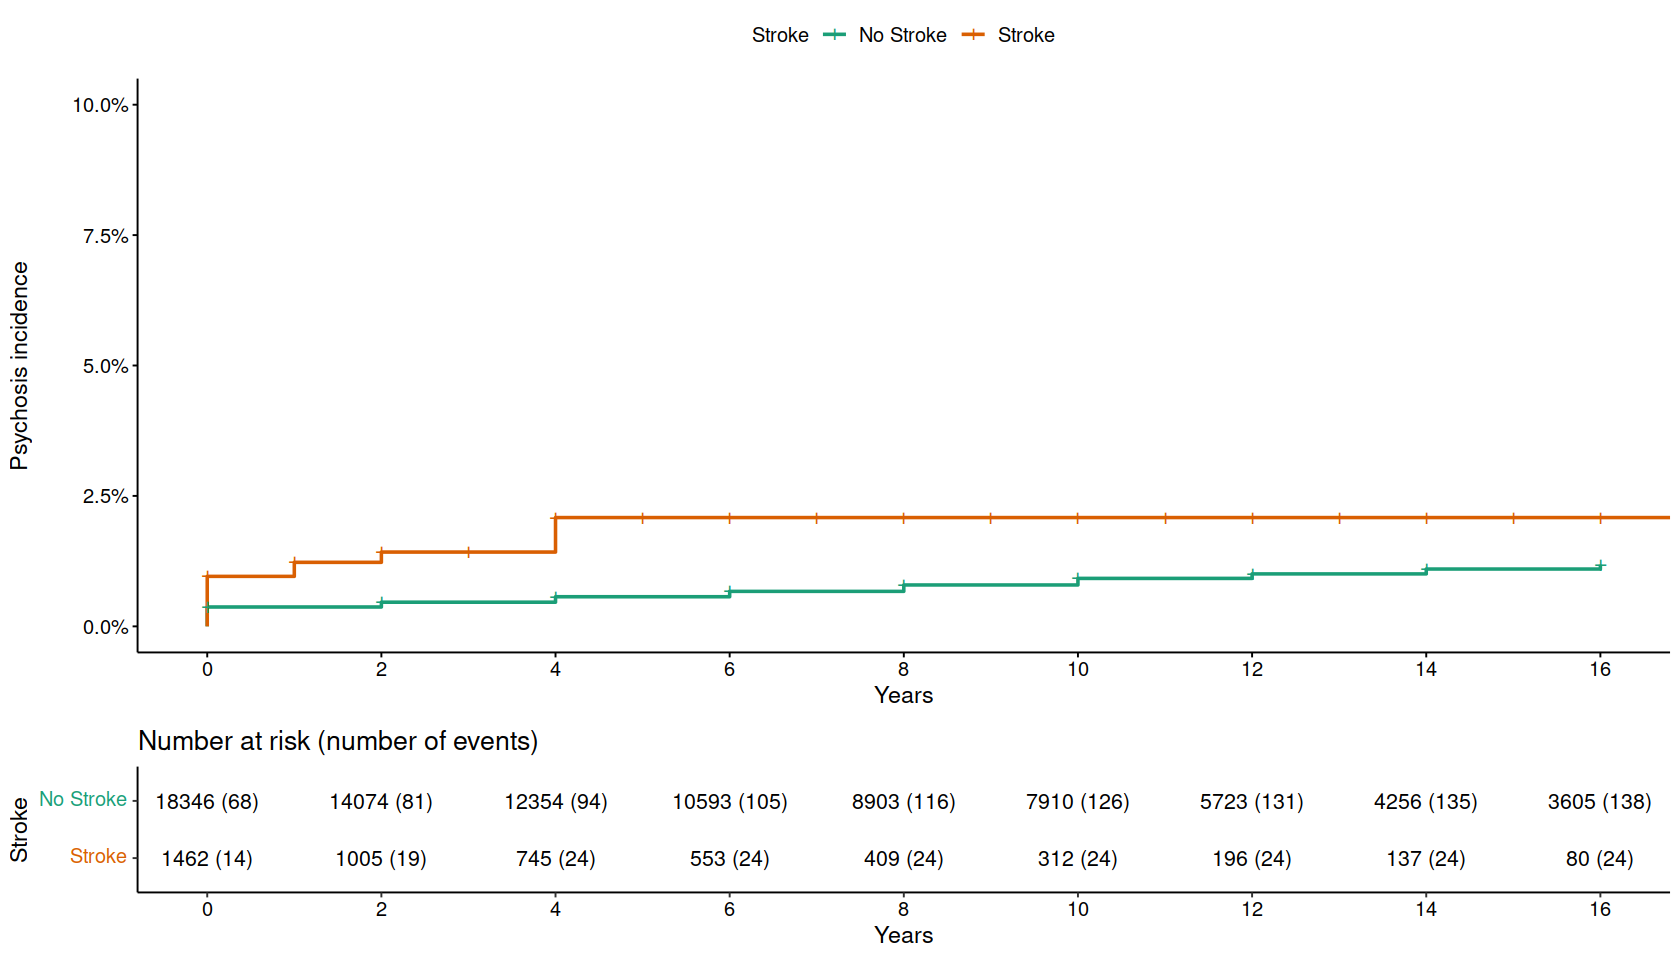

In [10]:
# Set plot size
options(repr.plot.width=14, repr.plot.height=8)

# Plot
ggsurvplot(
  psychosisinstroke_fit,         # survival object already created above
  data = psychosisinstroke_surv,
  conf.int = FALSE,              # whether to display CIs on plot
  fun = "event",
  surv.scale = "percent",        # present probabilities in the y axis in %
  break.time.by = 2,            # present the time axis with an increment of 1 days
  xlab = "Years",
  ylab = "Psychosis incidence",
  ylim = c(0, .10),
  pval = T,                      # print p-value of Log-rank test (this does not seem to appear?)
  pval.coord = c(40,.91),        # print p-value at these plot coordinates
  risk.table = "nrisk_cumevents",                # print the risk table at bottom. abs_pct = absolute numbers and percentages. Can also use "absolute" or "percentage" alone.
  legend.title = "Stroke",       # legend characteristics
  legend.labs = c("No Stroke","Stroke"),
  font.legend = 12, 
  palette = "Dark2",             # specify color palette 
  surv.median.line = "hv",       # draw horizontal and vertical lines to the median survivals (?but median  survival not met in this data)
)

### Cox proportional hazards regression models

#### Unadjusted model

<font color='red'>---------------------------------------------------------> *NOTE:* The following is in the 'unadjusted model' section but adjusts for sex</font>

In [11]:
psychosisinstroke_cox <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever*Sex, 
  data = psychosisinstroke_surv
)

summary(psychosisinstroke_cox)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever * 
    Sex, data = psychosisinstroke_surv)

  n= 19808, number of events= 162 

                        coef exp(coef) se(coef)     z Pr(>|z|)  
strokeever           0.46801   1.59681  0.40025 1.169   0.2423  
SexFemale            0.06465   1.06678  0.17210 0.376   0.7072  
strokeever:SexFemale 0.82876   2.29048  0.48094 1.723   0.0848 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                     exp(coef) exp(-coef) lower .95 upper .95
strokeever               1.597     0.6262    0.7287     3.499
SexFemale                1.067     0.9374    0.7614     1.495
strokeever:SexFemale     2.290     0.4366    0.8924     5.879

Concordance= 0.547  (se = 0.024 )
Likelihood ratio test= 19.82  on 3 df,   p=2e-04
Wald test            = 27.05  on 3 df,   p=6e-06
Score (logrank) test = 31.02  on 3 df,   p=8e-07


Test proportional hazards

In [12]:
cox.zph(psychosisinstroke_cox) # p values are not significant, suggesting the assumptions are not violated

               chisq df     p
strokeever     0.849  1 0.357
Sex            3.408  1 0.065
strokeever:Sex 0.213  1 0.644
GLOBAL         4.602  3 0.203

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


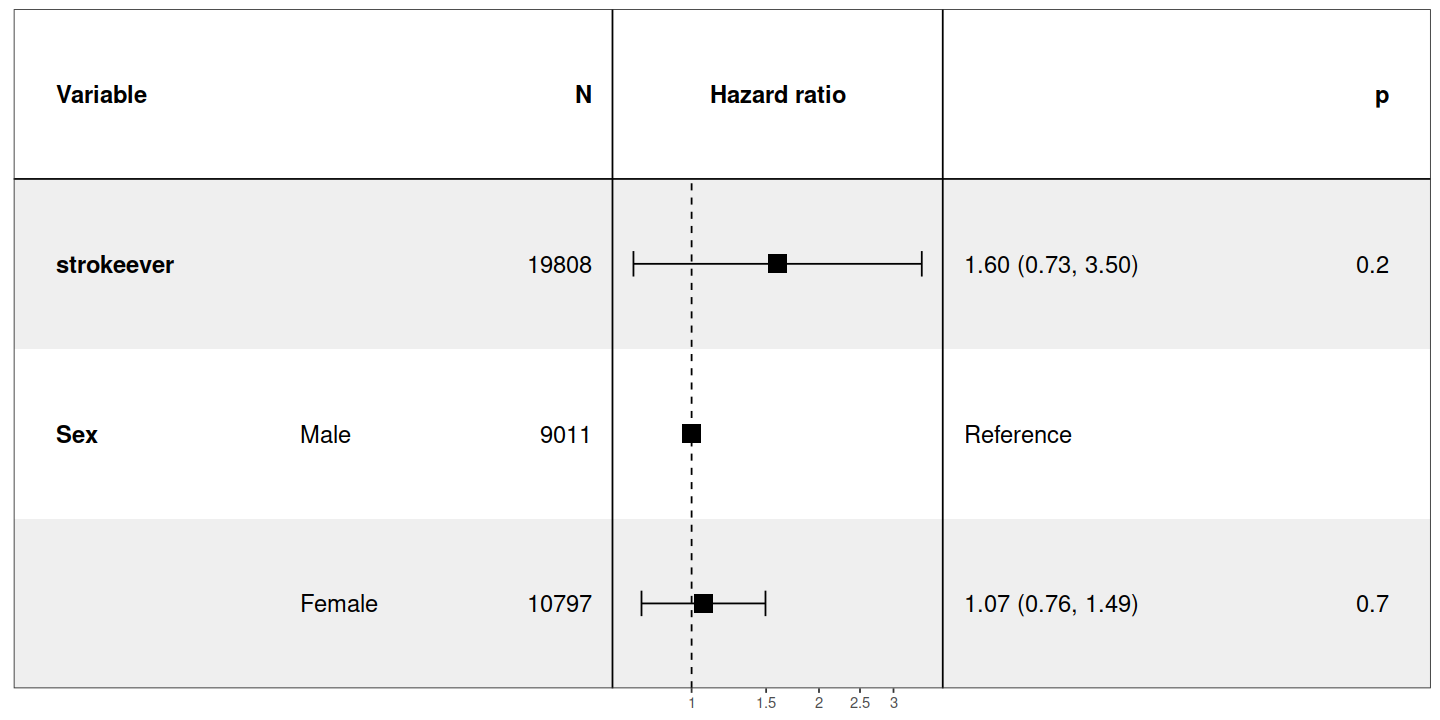

In [13]:
# Set plot size
options(repr.plot.width=12, repr.plot.height=6)

forest_model(psychosisinstroke_cox)

#### Adjusted model 1 (with demographic covariates)

In [14]:
psychosisinstroke_coxadj <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ `Stroke status`*Sex + `Age at Wave 1` + `Ethnic group` + `Wealth quintile` + frailty(idauniq), 
  data = psychosisinstroke_surv
)

summary(psychosisinstroke_coxadj)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ `Stroke status` * 
    Sex + `Age at Wave 1` + `Ethnic group` + `Wealth quintile` + 
    frailty(idauniq), data = psychosisinstroke_surv)

  n= 16434, number of events= 145 
   (3374 observations deleted due to missingness)

                          coef     se(coef) se2      Chisq   DF   p      
`Stroke status`            0.67293 0.559562 0.458128    1.45    1 2.3e-01
SexFemale                  0.08736 0.229171 0.189059    0.15    1 7.0e-01
`Age at Wave 1`           -0.03028 0.009771 0.008273    9.60    1 1.9e-03
`Ethnic group`Non-White   -0.23118 0.585244 0.480275    0.16    1 6.9e-01
`Ethnic group`Unknown      0.50878 0.552359 0.468553    0.85    1 3.6e-01
`Wealth quintile`4         0.32596 0.385691 0.334135    0.71    1 4.0e-01
`Wealth quintile`3         0.45071 0.384520 0.331482    1.37    1 2.4e-01
`Wealth quintile`2         0.65912 0.377348 0.323609    3.05    1 8.1e-02
`Wealth quintile`1         1.65870 0.338140 0.

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


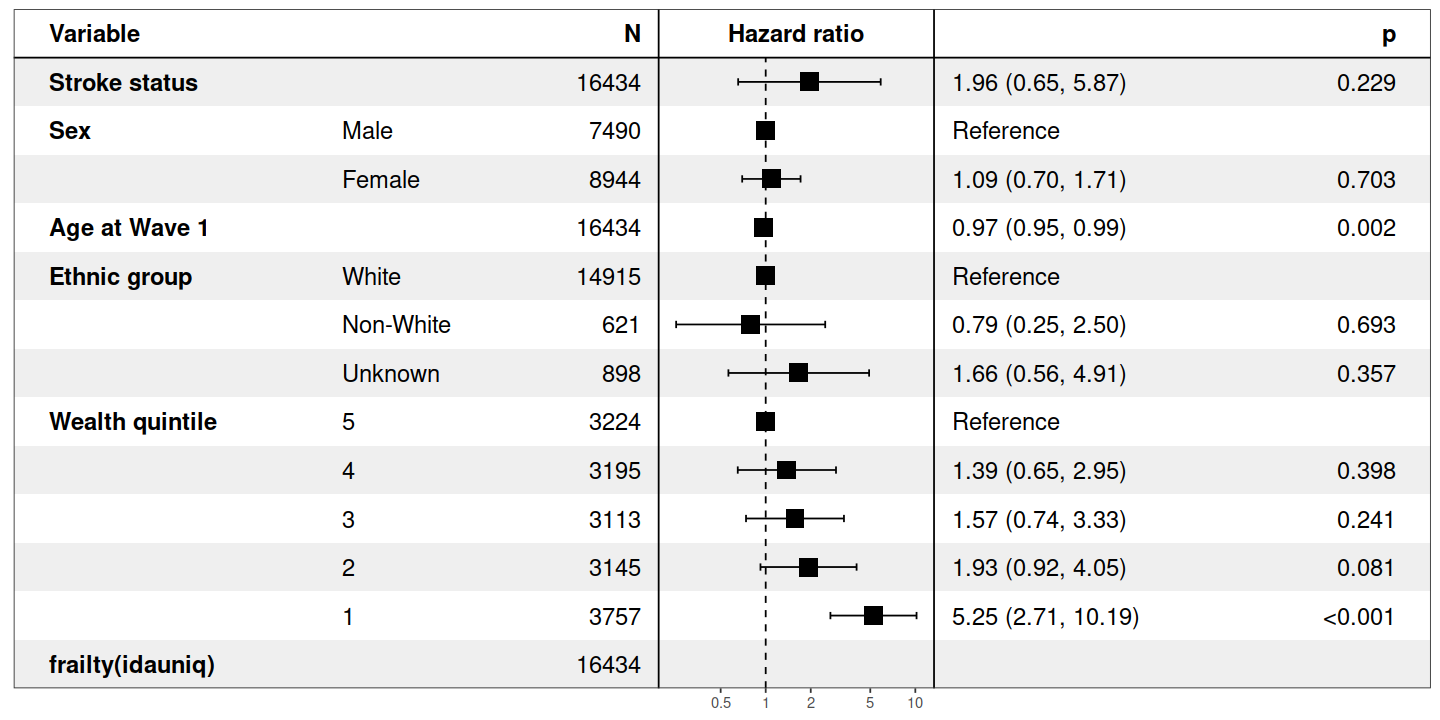

In [15]:
forest_model(psychosisinstroke_coxadj)

#### Adjusted model 2 (with demographic and health behaviour covariates)

In [16]:
psychosisinstroke_coxadj2 <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ `Stroke status` + `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + `Smoking status` + `Alcohol consumption` + `Vigorous activity` + frailty(idauniq), 
  data = psychosisinstroke_surv
)

summary(psychosisinstroke_coxadj2)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ `Stroke status` + 
    `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + 
    `Smoking status` + `Alcohol consumption` + `Vigorous activity` + 
    frailty(idauniq), data = psychosisinstroke_surv)

  n= 14895, number of events= 126 
   (4913 observations deleted due to missingness)

                        coef     se(coef) se2      Chisq   DF   p      
`Stroke status`          1.42621 0.42814  0.319731   11.10    1 8.6e-04
`Age at Wave 1`         -0.04610 0.01228  0.009832   14.10    1 1.7e-04
SexFemale                0.12825 0.26577  0.206555    0.23    1 6.3e-01
`Ethnic group`Non-White -0.04693 0.69825  0.516487    0.00    1 9.5e-01
`Ethnic group`Unknown    0.34700 0.67367  0.555209    0.27    1 6.1e-01
`Wealth quintile`4       0.27603 0.43936  0.355145    0.39    1 5.3e-01
`Wealth quintile`3       0.43984 0.43882  0.353087    1.00    1 3.2e-01
`Wealth quintile`2       0.23904 0.44597  0.357322    0.29    1 5.

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


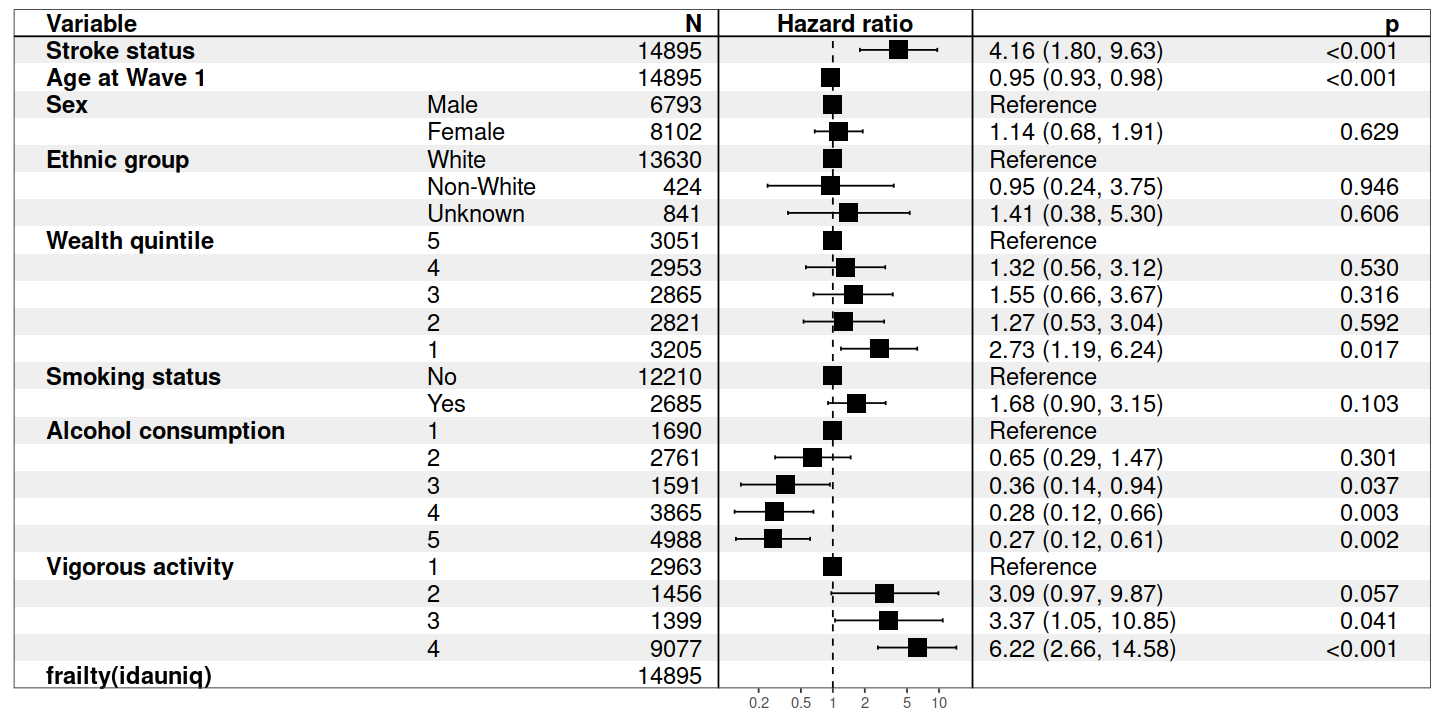

In [17]:
forest_model(psychosisinstroke_coxadj2)

### Sex-stratified analysis

Select females only

In [18]:
psychosisinstroke_female <- psychosisinstroke_surv %>%
  filter(Sex == "Female")

#### Females unadjusted analysis

In [19]:
psychosisinstroke_coxfemale <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever, 
  data = psychosisinstroke_female
)

summary(psychosisinstroke_coxfemale)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever, 
    data = psychosisinstroke_female)

  n= 10797, number of events= 96 

             coef exp(coef) se(coef)     z Pr(>|z|)    
strokeever 1.3301    3.7814   0.2691 4.943 7.68e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

           exp(coef) exp(-coef) lower .95 upper .95
strokeever     3.781     0.2645     2.232     6.407

Concordance= 0.573  (se = 0.022 )
Likelihood ratio test= 18.3  on 1 df,   p=2e-05
Wald test            = 24.44  on 1 df,   p=8e-07
Score (logrank) test = 28.23  on 1 df,   p=1e-07


#### Females adjusted model 1 (with demographic covariates)

In [20]:
psychosisinstroke_coxadjfemale <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ `Stroke status` + `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + frailty(idauniq), 
  data = psychosisinstroke_female
)

summary(psychosisinstroke_coxadjfemale)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ `Stroke status` + 
    `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + 
    frailty(idauniq), data = psychosisinstroke_female)

  n= 8944, number of events= 86 
   (1853 observations deleted due to missingness)

                        coef     se(coef) se2      Chisq DF    p      
`Stroke status`          1.33337 0.2951   0.293091 20.42  1.00 6.2e-06
`Age at Wave 1`         -0.01167 0.0100   0.009972  1.36  1.00 2.4e-01
SexFemale                        0.0000   0.000000        1.00        
`Ethnic group`Non-White -0.02919 0.5966   0.594510  0.00  1.00 9.6e-01
`Ethnic group`Unknown    0.98485 0.4913   0.489264  4.02  1.00 4.5e-02
`Wealth quintile`4       0.19436 0.3746   0.373539  0.27  1.00 6.0e-01
`Wealth quintile`3      -0.18129 0.4116   0.410586  0.19  1.00 6.6e-01
`Wealth quintile`2       0.17438 0.3773   0.376223  0.21  1.00 6.4e-01
`Wealth quintile`1       0.66647 0.3369   0.335813  3.91  1.00 4.8e-02
fr

#### Females adjusted model 2 (with demographic and health behaviour covariates)

In [21]:
psychosisinstroke_coxadj2female <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ `Stroke status` + `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + `Smoking status` + `Alcohol consumption` + `Vigorous activity` + frailty(idauniq), 
  data = psychosisinstroke_female
)

summary(psychosisinstroke_coxadj2female)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ `Stroke status` + 
    `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + 
    `Smoking status` + `Alcohol consumption` + `Vigorous activity` + 
    frailty(idauniq), data = psychosisinstroke_female)

  n= 8102, number of events= 77 
   (2695 observations deleted due to missingness)

                        coef      se(coef) se2     Chisq   DF   p     
`Stroke status`          1.645846 0.50694  0.38252   10.54    1 0.0012
`Age at Wave 1`         -0.036513 0.01499  0.01214    5.93    1 0.0150
SexFemale                         0.00000  0.00000            1       
`Ethnic group`Non-White  0.148717 0.88251  0.65634    0.03    1 0.8700
`Ethnic group`Unknown    0.851832 0.78351  0.64848    1.18    1 0.2800
`Wealth quintile`4       0.129849 0.50862  0.40181    0.07    1 0.8000
`Wealth quintile`3      -0.352201 0.54232  0.43740    0.42    1 0.5200
`Wealth quintile`2      -0.006718 0.51721  0.40928    0.00    1 0.9900
`We

#### Males only

In [22]:
psychosisinstroke_male <- psychosisinstroke_surv %>%
  filter(Sex == "Male")

#### Males unadjusted analysis

In [23]:
psychosisinstroke_coxmale <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever, 
  data = psychosisinstroke_male
)

summary(psychosisinstroke_coxmale)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever, 
    data = psychosisinstroke_male)

  n= 9011, number of events= 66 

             coef exp(coef) se(coef)     z Pr(>|z|)
strokeever 0.4231    1.5267   0.4006 1.056    0.291

           exp(coef) exp(-coef) lower .95 upper .95
strokeever     1.527      0.655    0.6963     3.348

Concordance= 0.521  (se = 0.021 )
Likelihood ratio test= 1  on 1 df,   p=0.3
Wald test            = 1.12  on 1 df,   p=0.3
Score (logrank) test = 1.13  on 1 df,   p=0.3


#### Males adjusted model 1 (with demographic covariates)

In [24]:
psychosisinstroke_coxadjmale <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ `Stroke status` + `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + frailty(idauniq), 
  data = psychosisinstroke_male
)

summary(psychosisinstroke_coxadjmale)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ `Stroke status` + 
    `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + 
    frailty(idauniq), data = psychosisinstroke_male)

  n= 7490, number of events= 59 
   (1521 observations deleted due to missingness)

                        coef     se(coef) se2     Chisq  DF   p      
`Stroke status`          0.74330 0.60228  0.48219   1.52    1 2.2e-01
`Age at Wave 1`         -0.04705 0.01633  0.01394   8.30    1 4.0e-03
SexFemale                        0.00000  0.00000           1        
`Ethnic group`Non-White -0.65763 0.92170  0.75918   0.51    1 4.8e-01
`Ethnic group`Unknown   -0.43405 1.13925  1.03548   0.15    1 7.0e-01
`Wealth quintile`4       0.07013 0.76198  0.70876   0.01    1 9.3e-01
`Wealth quintile`3       1.31718 0.66064  0.59657   3.98    1 4.6e-02
`Wealth quintile`2       1.13786 0.68352  0.61814   2.77    1 9.6e-02
`Wealth quintile`1       2.61337 0.60440  0.55091  18.70    1 1.5e-05
frailty(idauni

#### Males adjusted model 2 (with demographic and health behaviour covariates)

In [25]:
psychosisinstroke_coxadj2male <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ `Stroke status` + `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + `Smoking status` + `Alcohol consumption` + `Vigorous activity` + frailty(idauniq), 
  data = psychosisinstroke_male
)

summary(psychosisinstroke_coxadj2male)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ `Stroke status` + 
    `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + 
    `Smoking status` + `Alcohol consumption` + `Vigorous activity` + 
    frailty(idauniq), data = psychosisinstroke_male)

  n= 6793, number of events= 49 
   (2218 observations deleted due to missingness)

                        coef     se(coef) se2     Chisq  DF   p      
`Stroke status`          0.64524 0.65731  0.53257   0.96    1 0.33000
`Age at Wave 1`         -0.05428 0.01886  0.01598   8.28    1 0.00400
SexFemale                        0.00000  0.00000           1        
`Ethnic group`Non-White -0.25865 0.98680  0.79837   0.07    1 0.79000
`Ethnic group`Unknown   -0.34264 1.18509  1.06162   0.08    1 0.77000
`Wealth quintile`4       0.41645 0.83632  0.77151   0.25    1 0.62000
`Wealth quintile`3       1.56122 0.73961  0.67059   4.46    1 0.03500
`Wealth quintile`2       0.69679 0.81713  0.74464   0.73    1 0.39000
`Wealth quinti

### Age stratified analysis

#### Age <60

In [26]:
psychosisinstroke_ageless60 <- psychosisinstroke_surv %>%
  filter(age_cat == "<60")

#### Age <60 unadjusted analysis

In [27]:
psychosisinstroke_coxageless60 <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever, 
  data = psychosisinstroke_ageless60
)

summary(psychosisinstroke_coxageless60)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever, 
    data = psychosisinstroke_ageless60)

  n= 11465, number of events= 111 

             coef exp(coef) se(coef)     z Pr(>|z|)   
strokeever 1.1046    3.0181   0.3483 3.172  0.00152 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

           exp(coef) exp(-coef) lower .95 upper .95
strokeever     3.018     0.3313     1.525     5.973

Concordance= 0.532  (se = 0.015 )
Likelihood ratio test= 7.5  on 1 df,   p=0.006
Wald test            = 10.06  on 1 df,   p=0.002
Score (logrank) test = 11.12  on 1 df,   p=9e-04


#### Age <60 adjusted model 1 (with demographic covariates)

In [28]:
psychosisinstroke_coxageless60 <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever, 
  data = psychosisinstroke_ageless60
)

summary(psychosisinstroke_coxageless60)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever, 
    data = psychosisinstroke_ageless60)

  n= 11465, number of events= 111 

             coef exp(coef) se(coef)     z Pr(>|z|)   
strokeever 1.1046    3.0181   0.3483 3.172  0.00152 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

           exp(coef) exp(-coef) lower .95 upper .95
strokeever     3.018     0.3313     1.525     5.973

Concordance= 0.532  (se = 0.015 )
Likelihood ratio test= 7.5  on 1 df,   p=0.006
Wald test            = 10.06  on 1 df,   p=0.002
Score (logrank) test = 11.12  on 1 df,   p=9e-04


#### Age <60 adjusted model 2 (with demographic and health behaviour covariates)

In [29]:
psychosisinstroke_coxadj2ageless60 <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ `Stroke status` + `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + `Smoking status` + `Alcohol consumption` + `Vigorous activity` + frailty(idauniq), 
  data = psychosisinstroke_ageless60
)

summary(psychosisinstroke_coxadj2ageless60)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ `Stroke status` + 
    `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + 
    `Smoking status` + `Alcohol consumption` + `Vigorous activity` + 
    frailty(idauniq), data = psychosisinstroke_ageless60)

  n= 7213, number of events= 78 
   (4252 observations deleted due to missingness)

                        coef     se(coef) se2     Chisq  DF   p      
`Stroke status`          0.62135 0.71159  0.52686   0.76    1 0.38000
`Age at Wave 1`         -0.02055 0.02779  0.02232   0.55    1 0.46000
SexFemale               -0.08888 0.32628  0.25668   0.07    1 0.79000
`Ethnic group`Non-White  0.32428 0.73679  0.54392   0.19    1 0.66000
`Ethnic group`Unknown    0.91482 0.88980  0.67304   1.06    1 0.30000
`Wealth quintile`4       0.52362 0.59038  0.50154   0.79    1 0.38000
`Wealth quintile`3       0.67599 0.60439  0.51265   1.25    1 0.26000
`Wealth quintile`2       0.45638 0.60283  0.50635   0.57    1 0.45000
`Wealth q

#### Age 60-69

In [30]:
psychosisinstroke_age60to69 <- psychosisinstroke_surv %>%
  filter(age_cat == "60-69")

#### Age 60-69 unadjusted analysis

In [31]:
psychosisinstroke_coxage60to69 <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever, 
  data = psychosisinstroke_age60to69
)

summary(psychosisinstroke_coxage60to69)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever, 
    data = psychosisinstroke_age60to69)

  n= 4280, number of events= 24 

             coef exp(coef) se(coef)     z Pr(>|z|)  
strokeever 1.1728    3.2311   0.5064 2.316   0.0206 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

           exp(coef) exp(-coef) lower .95 upper .95
strokeever     3.231     0.3095     1.198     8.717

Concordance= 0.577  (se = 0.046 )
Likelihood ratio test= 4.24  on 1 df,   p=0.04
Wald test            = 5.36  on 1 df,   p=0.02
Score (logrank) test = 6  on 1 df,   p=0.01


#### Age 60-69 adjusted model 1 (with demographic covariates)

In [32]:
psychosisinstroke_coxadjage60to69 <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ `Stroke status` + `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + frailty(idauniq), 
  data = psychosisinstroke_age60to69
)

summary(psychosisinstroke_coxadjage60to69)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ `Stroke status` + 
    `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + 
    frailty(idauniq), data = psychosisinstroke_age60to69)

  n= 4042, number of events= 23 
   (238 observations deleted due to missingness)

                        coef     se(coef)  se2       Chisq DF p    
`Stroke status`           0.8601 5.604e-01 5.604e-01 2.36  1  0.120
`Age at Wave 1`          -0.0331 7.427e-02 7.427e-02 0.20  1  0.660
SexFemale                 0.8862 4.761e-01 4.761e-01 3.46  1  0.063
`Ethnic group`Non-White -19.2614 1.819e+04 1.819e+04 0.00  1  1.000
`Ethnic group`Unknown   -19.1668 2.110e+04 2.110e+04 0.00  1  1.000
`Wealth quintile`4       -0.1666 7.641e-01 7.641e-01 0.05  1  0.830
`Wealth quintile`3        0.6477 6.485e-01 6.485e-01 1.00  1  0.320
`Wealth quintile`2        0.1402 7.685e-01 7.685e-01 0.03  1  0.860
`Wealth quintile`1        1.0564 6.333e-01 6.333e-01 2.78  1  0.095
frailty(idauniq)              

#### Age 60-69 adjusted model 2 (with demographic and health behaviour covariates)

In [33]:
psychosisinstroke_coxadj2age60to69 <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ `Stroke status` + `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + `Smoking status` + `Alcohol consumption` + `Vigorous activity` + frailty(idauniq), 
  data = psychosisinstroke_age60to69
)

summary(psychosisinstroke_coxadj2age60to69)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ `Stroke status` + 
    `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + 
    `Smoking status` + `Alcohol consumption` + `Vigorous activity` + 
    frailty(idauniq), data = psychosisinstroke_age60to69)

  n= 3887, number of events= 23 
   (393 observations deleted due to missingness)

                        coef     se(coef)  se2       Chisq DF    p    
`Stroke status`          0.84875 5.672e-01 5.620e-01  2.24  1.00 0.130
`Age at Wave 1`         -0.07376 7.636e-02 7.591e-02  0.93  1.00 0.330
SexFemale                0.44178 4.912e-01 4.891e-01  0.81  1.00 0.370
`Ethnic group`Non-White          0.000e+00 0.000e+00        1.00      
`Ethnic group`Unknown            0.000e+00 0.000e+00        1.00      
`Wealth quintile`4      -0.33393 7.704e-01 7.677e-01  0.19  1.00 0.660
`Wealth quintile`3       0.36315 6.598e-01 6.566e-01  0.30  1.00 0.580
`Wealth quintile`2      -0.30248 7.879e-01 7.849e-01  0.15  1.00 0.700
`

#### Age 70+

In [34]:
psychosisinstroke_age70plus <- psychosisinstroke_surv %>%
  filter(age_cat == "70+")

#### Age 70+ unadjusted analysis

In [35]:
psychosisinstroke_coxage70plus <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever, 
  data = psychosisinstroke_age70plus
)

summary(psychosisinstroke_coxage70plus)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever, 
    data = psychosisinstroke_age70plus)

  n= 4061, number of events= 27 

             coef exp(coef) se(coef)     z Pr(>|z|)    
strokeever 1.4444    4.2393   0.4052 3.565 0.000364 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

           exp(coef) exp(-coef) lower .95 upper .95
strokeever     4.239     0.2359     1.916     9.379

Concordance= 0.692  (se = 0.052 )
Likelihood ratio test= 10.7  on 1 df,   p=0.001
Wald test            = 12.71  on 1 df,   p=4e-04
Score (logrank) test = 14.99  on 1 df,   p=1e-04


#### Age 70+ adjusted model 1 (with demographic covariates)

In [36]:
psychosisinstroke_coxadjage70plus <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ `Stroke status` + `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + frailty(idauniq), 
  data = psychosisinstroke_age70plus
)

summary(psychosisinstroke_coxadjage70plus)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ `Stroke status` + 
    `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + 
    frailty(idauniq), data = psychosisinstroke_age70plus)

  n= 3888, number of events= 27 
   (173 observations deleted due to missingness)

                        coef      se(coef) se2     Chisq  DF   p      
`Stroke status`          2.395726 0.63597  0.53409  14.19    1 0.00017
`Age at Wave 1`         -0.004285 0.05295  0.04303   0.01    1 0.94000
SexFemale                0.659091 0.58025  0.47150   1.29    1 0.26000
`Ethnic group`Non-White           0.00000  0.00000           1        
`Ethnic group`Unknown    1.598907 0.99188  0.85327   2.60    1 0.11000
`Wealth quintile`4       0.312238 0.85758  0.66752   0.13    1 0.72000
`Wealth quintile`3      -0.378951 0.86654  0.68452   0.19    1 0.66000
`Wealth quintile`2      -0.105353 0.82746  0.65126   0.02    1 0.90000
`Wealth quintile`1      -0.462967 0.97457  0.78755   0.23    1 0.63000


#### Age 70+ adjusted model 2 (with demographic and health behaviour covariates)

In [37]:
psychosisinstroke_coxadj2age70plus <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ `Stroke status` + `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + `Smoking status` + `Alcohol consumption` + `Vigorous activity` + frailty(idauniq), 
  data = psychosisinstroke_age70plus
)

summary(psychosisinstroke_coxadj2age70plus)

Warning message in coxpenal.fit(X, Y, istrat, offset, init = init, control, weights = weights, :
“Inner loop failed to coverge for iterations 9 10”
Warning message in sqrt((diag(object$var2))[kk]):
“NaNs produced”
Warning message in sqrt((diag(object$var2))[kk]):
“NaNs produced”
Warning message in sqrt((diag(object$var2))[kk]):
“NaNs produced”
Warning message in sqrt((diag(object$var2))[kk]):
“NaNs produced”


Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ `Stroke status` + 
    `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + 
    `Smoking status` + `Alcohol consumption` + `Vigorous activity` + 
    frailty(idauniq), data = psychosisinstroke_age70plus)

  n= 3795, number of events= 25 
   (266 observations deleted due to missingness)

                        coef     se(coef) se2     Chisq  DF   p    
`Stroke status`          3.64052 1.1788   0.70814   9.54    1 0.002
`Age at Wave 1`          0.01691 0.1071   0.05952   0.02    1 0.870
SexFemale                0.41125 1.2268   0.54600   0.11    1 0.740
`Ethnic group`Non-White          0.0000   0.00000           1      
`Ethnic group`Unknown    0.22872 2.2929   1.56016   0.01    1 0.920
`Wealth quintile`4       0.20934 1.6479   0.80927   0.02    1 0.900
`Wealth quintile`3      -0.56996 1.9482             0.09    1 0.770
`Wealth quintile`2      -0.89399 1.7983             0.25    1 0.620
`Wealth quintile`1      -2.3

## Analysis platform details and software versions

In [38]:
version

               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          0.3                         
year           2020                        
month          10                          
day            10                          
svn rev        79318                       
language       R                           
version.string R version 4.0.3 (2020-10-10)
nickname       Bunny-Wunnies Freak Out     

In [39]:
packageVersion("dplyr")

[1] ‘1.0.9’

In [40]:
packageVersion("survival")

[1] ‘3.2.7’

In [41]:
packageVersion("survminer")

[1] ‘0.4.9’

In [42]:
packageVersion("forestmodel")

[1] ‘0.6.2’